<a href="https://colab.research.google.com/github/Artyom995/Artyom995/blob/main/Neuro_Parkinson's_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обнаружение болезни паркинсона с помощью XGBoost. Задача с помощью Data Science предсказать заболевание паркинсона на ранней стадии, используя алгоритм машинного обучения XGBoost и библиотеку sklearn для нормализации признаков.

Цели - самостоятельно изучить XGBoost.
Выборки делить в соотношении 80% обучающая, 20% - тестовая.
Дополнительные баллы - если сможешь получить точность более 95%.

Что такое болезнь Паркинсона? Болезнь Паркинсона - прогрессирующее заболевание центральной нервной системы, влияющее на движение и вызывающее тремор и скованность движений.

У нее 5 стадий, и ежегодно ею страдают более 1 миллиона человек только в одной Индии. Это хроническое заболевание, и его пока не лечат. Это нейродегенеративное расстройство, поражающее нейроны головного мозга, вырабатывающие дофамин.

Что такое XGBoost? XGBoost - это новый алгоритм машинного обучения, разработанный с учетом скорости и производительности.

XGBoost расшифровывается как экстремальное повышение градиента и основан на деревьях решений.

Многие считают его одним из лучших алгоритмов и из-за его высокой производительности при решении задач регрессии и классификации, рекомендуют его в качестве первого выбора во многих ситуациях. XGBoost прославился тем, что выиграл множество соревнований Kaggle

In [13]:
!pip install pandas numpy scikit-learn xgboost

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import cross_val_score

In [15]:
data = pd.read_csv('/content/parkinsons.data')
print(data.head(5))
print(data.shape)

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

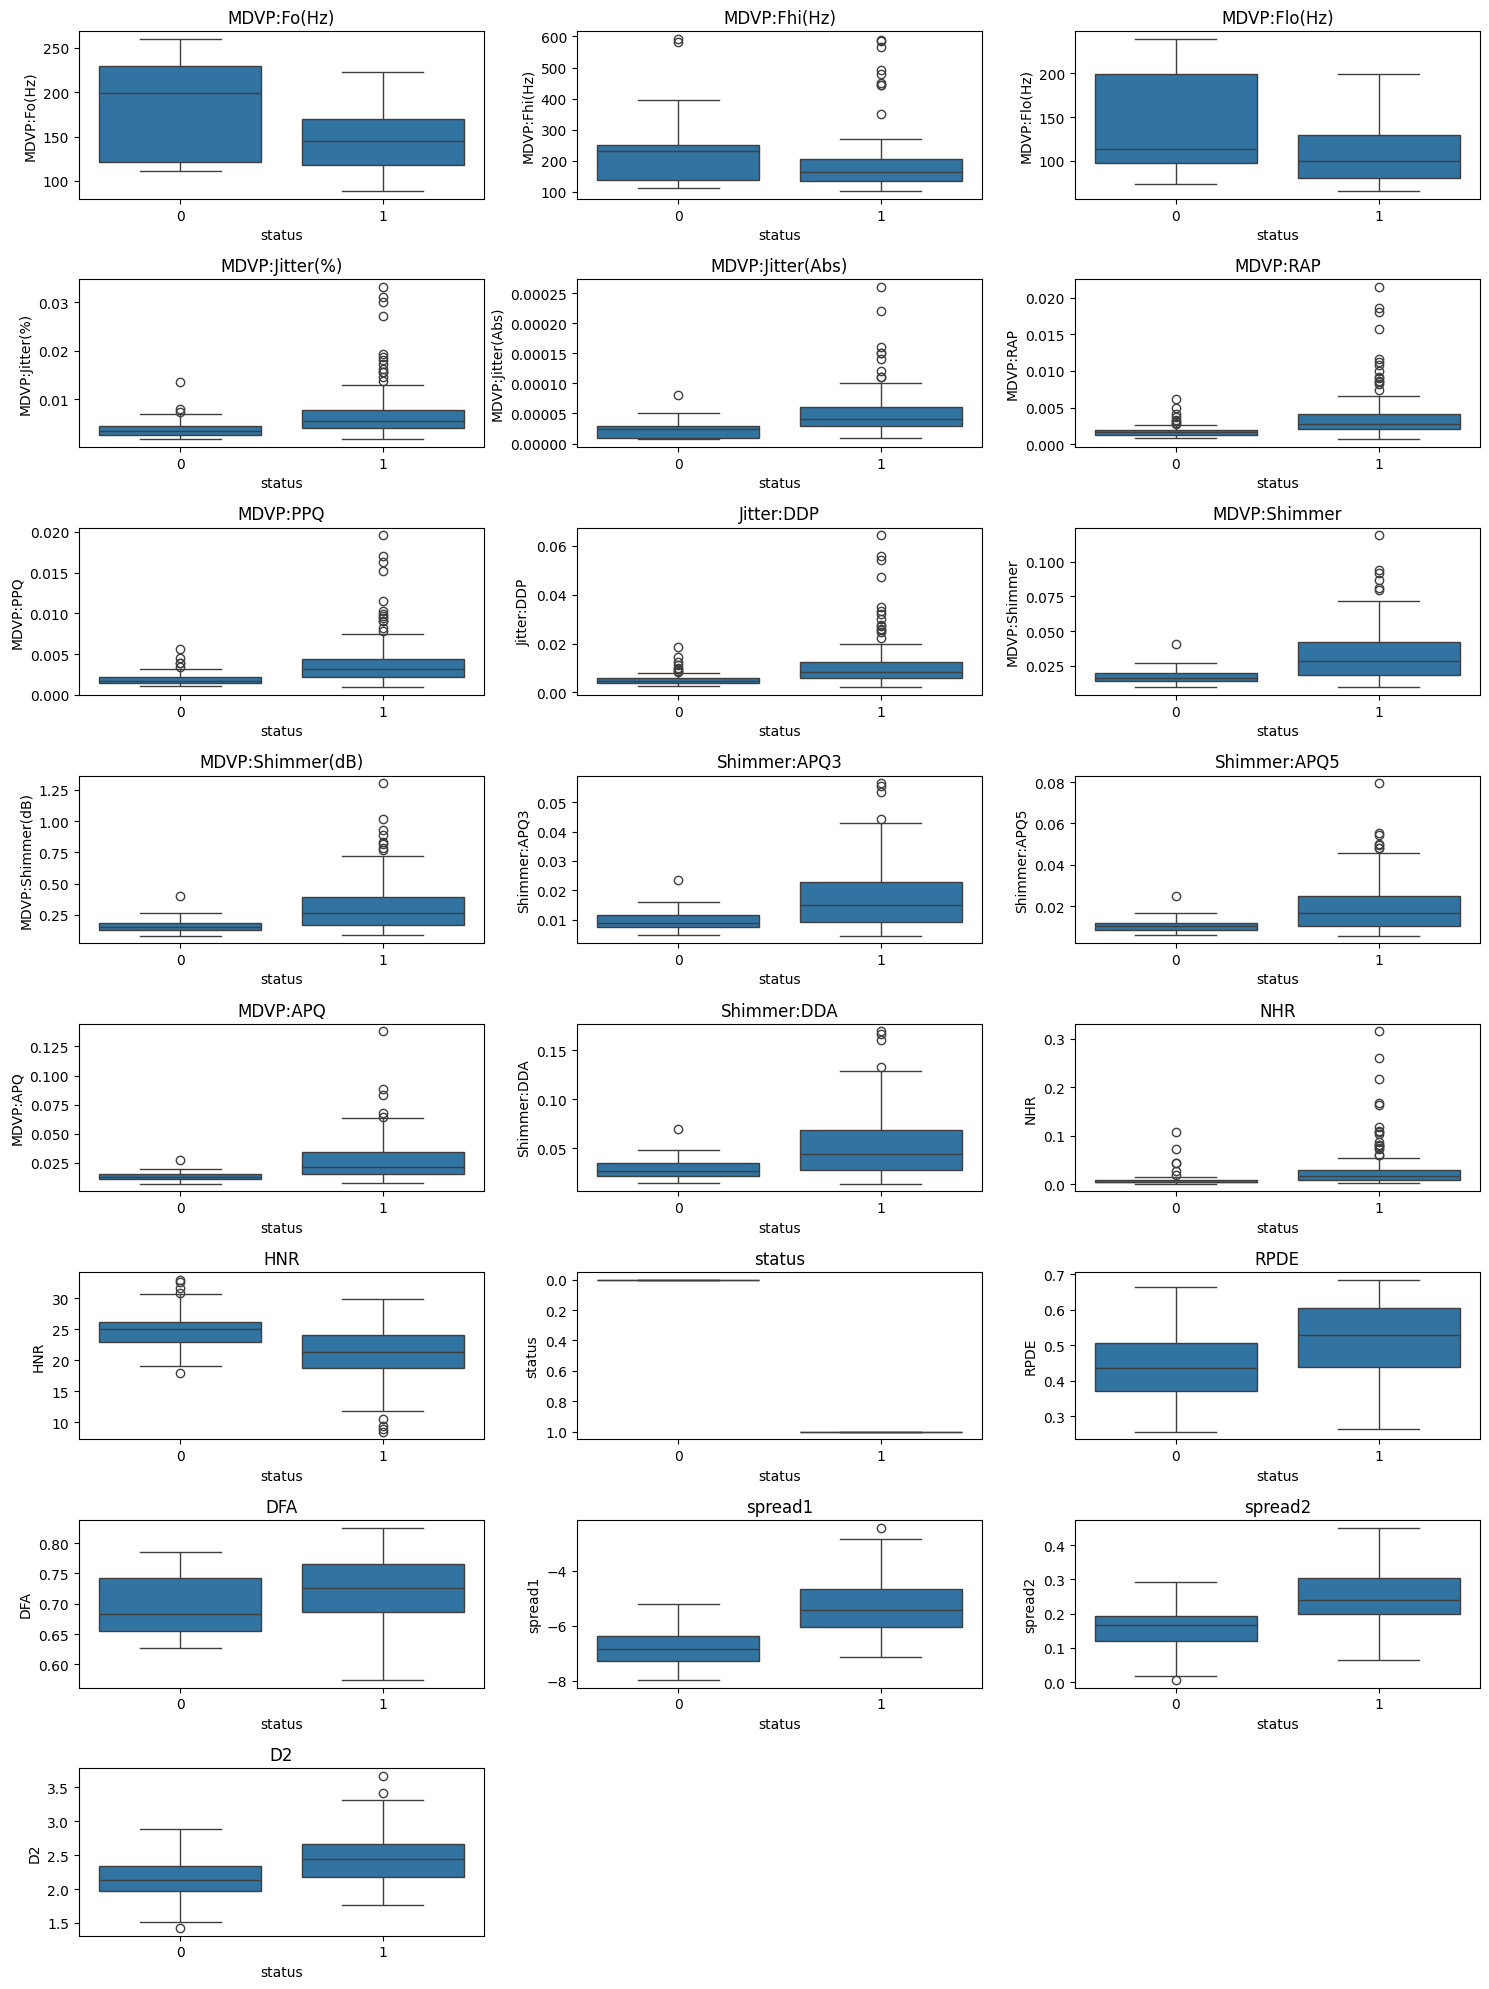

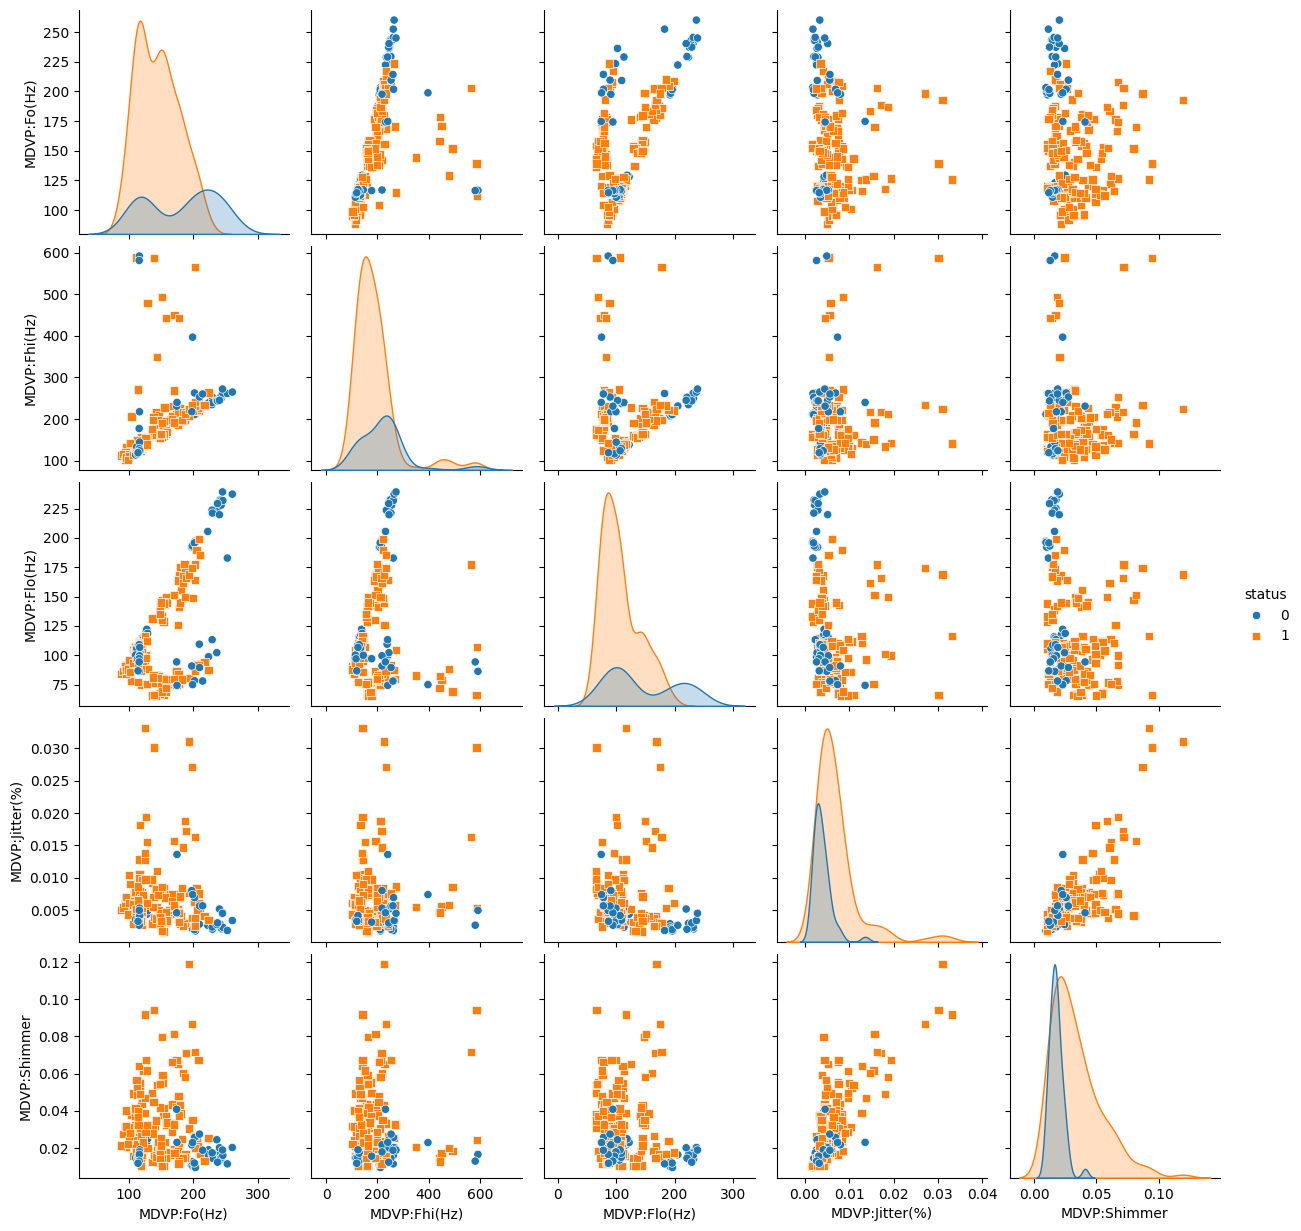

In [16]:
#целевая переменная 'status' является категориальной
data['status'] = data['status'].astype('category')

# Построение boxplot для каждого признака в зависимости от целевой переменной
features = data.columns[1:-1]  # Все признаки, кроме 'name' и 'status'

plt.figure(figsize=(15, 20))
for i, feature in enumerate(features):
    plt.subplot(len(features) // 3 + 1, 3, i + 1)
    sns.boxplot(x='status', y=feature, data=data)
    plt.title(feature)

plt.tight_layout()
plt.show()

# Построение pairplot для визуализации взаимосвязей между признаками
# Выбераем несколько признаков для pairplot, чтобы избежать перегрузки графика
selected_features = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Shimmer', 'status']
sns.pairplot(data[selected_features], hue='status', markers=["o", "s"])
plt.show()

In [17]:
with open('/content/parkinsons.names', 'r') as file:
    content = file.read()
    print(content)

Title: Parkinsons Disease Data Set

Abstract: Oxford Parkinson's Disease Detection Dataset

-----------------------------------------------------	

Data Set Characteristics: Multivariate
Number of Instances: 197
Area: Life
Attribute Characteristics: Real
Number of Attributes: 23
Date Donated: 2008-06-26
Associated Tasks: Classification
Missing Values? N/A

-----------------------------------------------------	

Source:

The dataset was created by Max Little of the University of Oxford, in 
collaboration with the National Centre for Voice and Speech, Denver, 
Colorado, who recorded the speech signals. The original study published the 
feature extraction methods for general voice disorders.

-----------------------------------------------------

Data Set Information:

This dataset is composed of a range of biomedical voice measurements from 
31 people, 23 with Parkinson's disease (PD). Each column in the table is a 
particular voice measure, and each row corresponds one of 195 voice 
rec

In [18]:
# Создание копии данных для аугментации
data_augmented = data.copy()

# Дублирование данных
data_augmented = pd.concat([data, data_augmented], ignore_index=True)

In [19]:
# Определение числовых столбцов
numeric_columns = data.select_dtypes(include=[np.number]).columns  # Выбор только числовых столбцов

# Создание новой переменной для данных с шумом
data_augmented_with_noise = data_augmented.copy()

# Добавление гауссовского шума ко всем числовым столбцам в новой переменной
for col in numeric_columns:
    # Проверка на наличие пропущенных значений
    if data_augmented_with_noise[col].isnull().any():
        print(f"В столбце {col} есть пропущенные значения. Шум не будет добавлен.")
        continue

    # Генерация шума
    noise = np.random.normal(0, 0.1 * data[col].std(), size=data_augmented_with_noise[col].shape)  # Шум с учетом стандартного отклонения
    data_augmented_with_noise[col] += noise  # Добавляем шум ко всем данным в новой переменной

# Убеждаемся, что значения остаются в разумных пределах
data_augmented_with_noise[numeric_columns] = data_augmented_with_noise[numeric_columns].clip(lower=0)  #ограничение снизу

# Проверка результата
print(data_augmented_with_noise.head(10))  # Печать первых 10 строк для проверки
print(data_augmented_with_noise.shape)  # Печать новой формы датасета

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1   117.524924    164.609393     81.865986        0.007190   
1  phon_R01_S01_2   121.025881    148.309501    112.551218        0.009549   
2  phon_R01_S01_3   115.167771    135.860409    110.171577        0.011391   
3  phon_R01_S01_4   121.379212    136.863290    103.508711        0.010639   
4  phon_R01_S01_5   110.922671    140.581061    109.807981        0.012659   
5  phon_R01_S01_6   129.058941    128.583708    117.165420        0.009518   
6  phon_R01_S02_1   125.202668    136.412631    120.194224        0.004049   
7  phon_R01_S02_2    99.549707    123.057500    101.340246        0.003372   
8  phon_R01_S02_3    96.708486    142.520566     94.145662        0.005714   
9  phon_R01_S02_4    93.191924    117.368559     88.700435        0.005346   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0          0.000071  0.003013  0.005201    0.011368      0.041869  

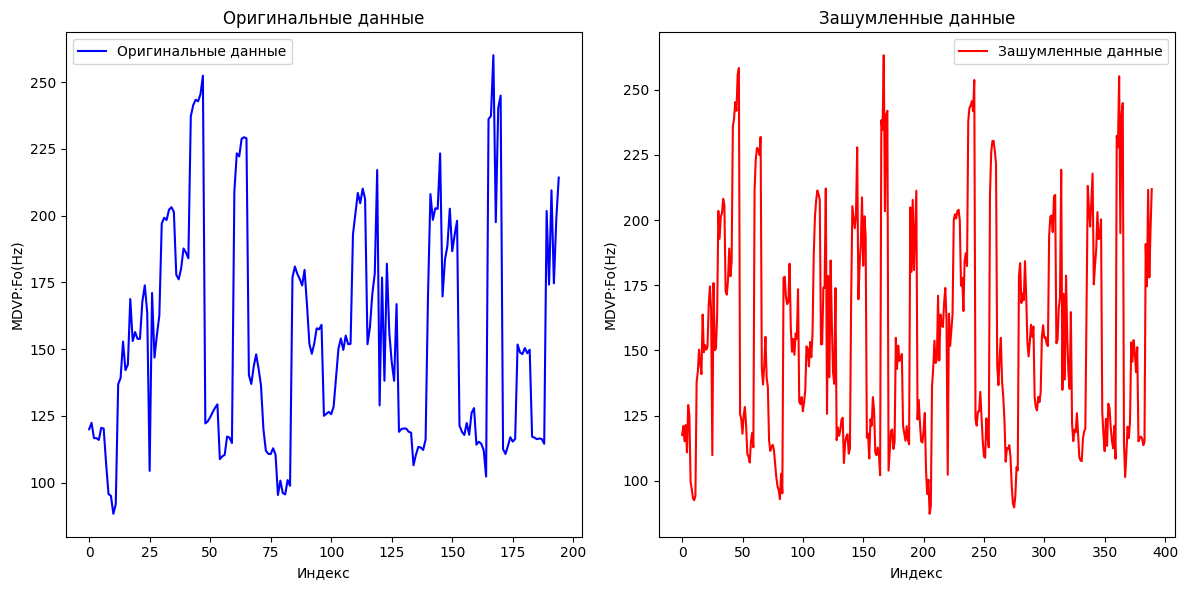

In [20]:
# Визуализация зашумленных значений
plt.figure(figsize=(12, 6))

# Оригинальные данные
plt.subplot(1, 2, 1)
plt.plot(data['MDVP:Fo(Hz)'], label='Оригинальные данные', color='blue')
plt.title('Оригинальные данные')
plt.xlabel('Индекс')
plt.ylabel('MDVP:Fo(Hz)')
plt.legend()

# Зашумленные данные
plt.subplot(1, 2, 2)
plt.plot(data_augmented_with_noise['MDVP:Fo(Hz)'], label='Зашумленные данные', color='red')
plt.title('Зашумленные данные')
plt.xlabel('Индекс')
plt.ylabel('MDVP:Fo(Hz)')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
#Обычная
# Фильтрафия столбцов
X = data_augmented_with_noise.drop(columns=['name', 'status'])  # Убираем 'name' и 'status' т.к не нужны в обучении
y = data_augmented_with_noise['status'] #переменная с здоров или нет используеться для обучения модели и оценки ее точности.


# смотрим на наши данные и вычисляем, какое у них среднее значение и насколько они разбросаны (стандартное отклонение).
scaler = StandardScaler() #приводим данные к общему масштабу, чтобы они имели среднее значение 0 и стандартное отклонение 1
X_scaled = scaler.fit_transform(X) #fit_transform вычисляет параметры (среднее и стандартное отклонение)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание и обучение модели
model = xgb.XGBClassifier(eval_metric='logloss')#val_metric='logloss' указывает, что мы будем использовать логарифмическую потерю (log loss) в качестве метрики для оценки качества модели во время обучения.
model.fit(X_train, y_train)#обучаем модель на обучающей выборке

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test) #метод для получения предсказаний модели на тестовой выборке
              #передаем стандартизированные признаки X_test, и модель возвращает предсказанные метки (0 или 1) для каждого примера


# Оценка точности
accuracy = accuracy_score(y_test, y_pred)#функция из библиотеки sklearn вычисляет точность, сравнивая y_pred с истинными метками y_test
print(f'Точность: {accuracy * 100:.2f}%')

# параметры для поиска
param_grid = { #словарь, который определяет набор гиперпараметров, которые мы хотим оптимизировать
    'max_depth': [3, 4, 5, 6], # максимальная глубина дерева. Чем больше глубина, тем более сложные модели могут быть построены
    'n_estimators': [100, 200, 300],#Количество деревьев. Большее количество деревьев может улучшить производительность, но также увеличивает время обучения.
    'learning_rate': [0.01, 0.1, 0.2],#Скорость обучения, которая контролирует, насколько сильно каждое дерево влияет на итоговое предсказание. Меньшие значения могут привести к более стабильным, но медленным результатам.
}

# Поиск по сетке
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)#перебирает все возможные комбинации параметров, указанных в param_grid, и оценивает каждую комбинацию с помощью кросс-валидации.
#estimator=model - модель, которую мы хотим оптимизировать param_grid=param_grid: словарь с гиперпараметрами, которые мы хотим оптимизировать.scoring='accuracy': указываем точность как метрику для оценки производительности модели.
#cv=3: Это количество фолдов для кросс-валидации(данные будут разделены на 3 части)
grid_search.fit(X_train, y_train) #метод запускает процесс поиска по сетке, обучая модель на каждой комбинации гиперпараметров и оценивая ее производительность


# Лучшая модель
best_model = grid_search.best_estimator_

# Прогнозирование и оценка точности
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Наилучшая точность: {best_accuracy * 100:.2f}%')

Точность: 97.44%
Наилучшая точность: 96.15%


In [22]:
#С кросс валидацией
# Фильтрация столбцов
X = data_augmented_with_noise.drop(columns=['name', 'status'])  # Убираем 'name' и 'status' т.к. не нужны в обучении
y = data_augmented_with_noise['status']  # Переменная с "здоров" или "нет", используется для обучения модели и оценки ее точности.

# Смотрим на наши данные и вычисляем, какое у них среднее значение и насколько они разбросаны (стандартное отклонение).
scaler = StandardScaler()  # Приводим данные к общему масштабу, чтобы они имели среднее значение 0 и стандартное отклонение 1
X_scaled = scaler.fit_transform(X)  # fit_transform вычисляет параметры (среднее и стандартное отклонение)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.24, random_state=42)

# Создание и обучение модели
model = xgb.XGBClassifier(eval_metric='logloss')  # val_metric='logloss' указывает, что мы будем использовать логарифмическую потерю (log loss) в качестве метрики для оценки качества модели во время обучения.
model.fit(X_train, y_train)  # Обучаем модель на обучающей выборке

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)  # Метод для получения предсказаний модели на тестовой выборке

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)  # Функция из библиотеки sklearn вычисляет точность, сравнивая y_pred с истинными метками y_test
print(f'Точность: {accuracy * 100:.2f}%')

# Кросс-валидация
cv_scores = cross_val_score(model, X_scaled, y, cv=10)  # 5-фолдовая кросс-валидация
print(f'Средняя точность кросс-валидации: {cv_scores.mean() * 100:.2f}%')

# Параметры для поиска
param_grid = {  # Словарь, который определяет набор гиперпараметров, которые мы хотим оптимизировать
    'max_depth': [3, 4, 5, 6],  # Максимальная глубина дерева. Чем больше глубина, тем более сложные модели могут быть построены
    'n_estimators': [100, 200, 300],  # Количество деревьев. Большее количество деревьев может улучшить производительность, но также увеличивает время обучения.
    'learning_rate': [0.01, 0.1, 0.2],  # Скорость обучения, которая контролирует, насколько сильно каждое дерево влияет на итоговое предсказание. Меньшие значения могут привести к более стабильным, но медленным результатам.
}

# Поиск по сетке
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)  # Перебирает все возможные комбинации параметров
grid_search.fit(X_train, y_train)  # Метод запускает процесс поиска по сетке

# Лучшая модель
best_model = grid_search.best_estimator_

# Прогнозирование и оценка точности
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Наилучшая точность: {best_accuracy * 100:.2f}%')

# Кросс-валидация для лучшей модели
best_cv_scores = cross_val_score(best_model, X_scaled, y, cv=10)  # 5-фолдовая кросс-валидация для лучшей модели
print(f'Средняя точность кросс-валидации для лучшей модели: {best_cv_scores.mean() * 100:.2f}%')

Точность: 96.81%
Средняя точность кросс-валидации: 93.08%
Наилучшая точность: 96.81%
Средняя точность кросс-валидации для лучшей модели: 93.85%
